In [37]:
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")  # Ignores all warnings


In [38]:
end = dt.datetime.now()
start = dt.datetime(2020,1,1)

df = yf.download(['BTC-USD'], start, end)
Close = df.Close
Close.tail()

[*********************100%%**********************]  1 of 1 completed


Date
2024-11-22    98997.664062
2024-11-23    97777.281250
2024-11-24    98013.820312
2024-11-25    93102.296875
2024-11-26    94204.648438
Name: Close, dtype: float64

(0.6134935848269102, 94204.6484375)

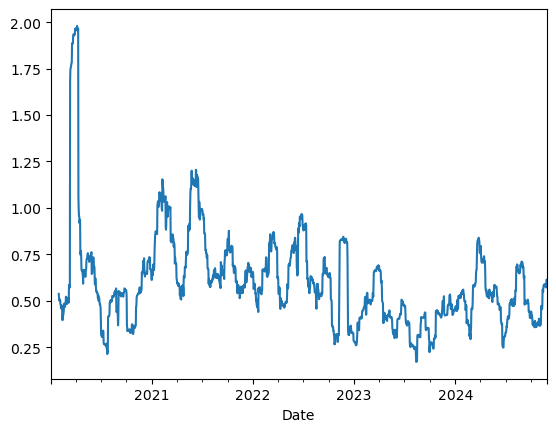

In [44]:
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()

TRADING_DAYS = 30
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(365)

volatility.plot()
volatility.iloc[-1], Close.iloc[-1]

# Implied Volatility

In [19]:
## required for installing py_vollib
!pip install py_vollib

In [31]:
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta

def implied_vol(S0, K, T, r, market_price, flag='c', tol=0.00001):
    """Calculating the implied volatility of an European option
        S0: stock price
        K: strike price
        T: time to maturity
        r: risk-free rate
        market_price: option price in market
    """
    max_iter = 200 #max no. of iterations
    vol_old = 0.1 #initial guess

    for k in range(max_iter):
        bs_price = bs(flag, S0, K, T, r, vol_old)
        Cprime = vega(flag, S0, K, T, r, vol_old)*100
        C = bs_price - market_price

        vol_new = vol_old - C/Cprime
        new_bs_price = bs(flag, S0, K, T, r, vol_new)
        if (abs(vol_old-vol_new) < tol or abs(new_bs_price-market_price) < tol):
            break

        vol_old = vol_new

    implied_vol = vol_new
    return implied_vol

In [34]:
S0 = 7200.17
atm_options = [
[dt.date(2021,10,18),7200.17,[2.585,3.25],[4.600,5.300]],
]
call_bids,call_asks,put_bids,put_asks, = [],[],[],[]
IV_DTE = []

for i in atm_options:
    date, K = i[0], i[1]
    DTE = (date - dt.date(2021,7,30)).days
    T = DTE/365
    r = 0.02
    call_bid, call_ask = i[2]
    put_bid, put_ask = i[3]

    call_bids.append(implied_vol(S0, K, T, r, call_bid, flag='c')*100)
    call_asks.append(implied_vol(S0, K, T, r, call_ask, flag='c')*100)
    put_bids.append(implied_vol(S0, K, T, r, put_bid, flag='p')*100)
    put_asks.append(implied_vol(S0, K, T, r, put_ask, flag='p')*100)
    IV_DTE.append(DTE)

call_bids,call_asks,put_bids,put_asks

([-551.3610190344558],
 [-529.6982254161131],
 [1.1567986815253466],
 [1.2278235735014142])

In [22]:
K = 102
N = 11 # 11 weeks
sigma = 0.30
S0 = 102
DTE = (dt.date(2021,10,18) - dt.date(2021,7,30)).days
T = DTE/365
r = 0.02
DT = T/N
TTE = [DT*N-DT*i for i in range(0,N+1)]

In [23]:
def calc_delta(flag, price, K, time, r, sigma, position='s'):
    if time == 0:
        return np.nan
    else:
        if position=='l':
            return int(delta(flag, price, K, time, r, sigma)*100)
        else:
            return -int(delta(flag, price, K, time, r, sigma)*100)

def adjust(delta, total):
    if delta < 0:
        return 'Buy {0}'.format(abs(delta))
    elif delta > 0:
        return 'Sell {0}'.format(abs(delta))
    elif delta == 0:
        return 'None'
    else:
        if total < 0:
            return 'Sell {0}'.format(abs(total))
        elif total > 0:
            return 'Buy {0}'.format(abs(total))
        else:
            return np.nan

def totalAdj(counter,time):
    if time > 0:
        if counter < 0:
            return 'Long {0}'.format(abs(counter))
        elif counter > 0:
            return 'Short {0}'.format(abs(counter))
        else:
            return np.nan
    else:
            return np.nan

def cashAdj(delta, price, time, total):
    if time > 0:
        return delta*price
    else:
        return -total*price

In [24]:
Dynamic_Hedging_Results = pd.DataFrame(data=[], columns=[], index=['Original Option P&L','Original Stock P&L','Adjustment P&L', \
                                                                             'Carry (interest) on options', 'Carry (interest) on stock', \
                                                                             'Interest on Adjustments'])
Dynamic_Hedging_Results.index.name = 'Dynamic hedging results'

call_bid,call_ask,put_bid,put_ask = 2.585,3.25,4.600,5.300

# number of sims
M = 1000

# Realized Volatility
sigma = 0.12

# Position in Option contract
k = 102
position = 's'
flag = 'c'

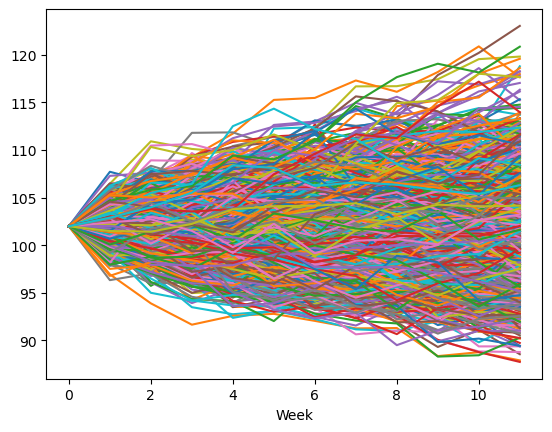

,Time,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
Week,,,,,,,,,,,,,,,,,,,,,
0,0.22,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,...,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
1,0.20,101.01,102.38,100.25,104.06,100.60,102.00,100.28,101.92,102.73,...,101.52,105.27,100.08,102.95,102.03,102.96,102.41,102.76,101.50,102.90
2,0.18,99.54,104.07,100.24,101.93,99.49,101.69,99.58,102.42,103.73,...,104.42,105.02,101.42,103.81,101.47,101.09,102.73,104.46,101.43,103.99
3,0.16,99.63,105.65,103.30,104.25,99.55,104.24,99.99,103.44,104.08,...,104.78,105.41,102.14,103.55,100.99,102.18,101.52,102.48,102.25,105.53
4,0.14,102.35,108.97,102.36,106.38,99.79,104.99,99.24,103.86,103.17,...,107.06,105.43,100.57,103.80,100.84,101.36,99.20,103.86,103.78,108.40
5,0.12,102.84,108.90,100.46,107.56,98.30,105.78,97.97,105.63,103.33,...,106.49,103.09,103.34,107.46,100.05,104.12,102.26,104.56,104.10,108.13
6,0.10,103.90,109.68,100.79,111.93,97.64,103.37,97.63,106.07,103.13,...,107.26,104.00,102.62,109.61,97.71,105.78,99.16,104.89,104.16,106.23
7,0.08,102.00,106.29,99.52,108.75,98.24,104.43,96.66,106.67,101.28,...,104.28,107.07,101.77,111.63,97.67,105.07,100.48,102.67,104.41,106.61
8,0.06,102.92,105.79,99.43,108.44,97.73,107.59,95.49,104.64,102.39,...,106.81,106.54,101.44,111.26,97.74,107.76,100.65,103.82,103.27,106.36


In [25]:
nudt = (r - 0.5*sigma**2) * DT
sigmasdt = sigma*np.sqrt(DT)

no_hedge = []
static_hedge = []

# number of sims

St = S0
St_series = [np.array([St for m in range(M)])]
for i in range(N):
    St = St_series[-1]
    Stn = np.round( St * np.exp(nudt + sigmasdt*np.random.normal(0,1,M)) , 2)
    St_series.append(Stn)

St_series = np.array(St_series)

df = pd.DataFrame(St_series, columns = [i for i in range(M)])
df.index.name = 'Week'
df.plot()
plt.legend().set_visible(False)
plt.show()
df.insert(0, "Time", np.round(TTE,2))
df

## Build up delta hedging dataframe with specific factors:
 - delta
 - total delta positions
 - number of adjustments
 - adjustment cashflow
 - interest on adjustments

 We can then sum the columns over the 11 weeks of delta heding and calculate the carry on options, carry on stock, option p&l, stock p&l and adjustment p&l and interest earned on adjustments.

In [26]:
for sim in range(M):
    hedgeSim = df.loc[:,['Time',sim]]
    hedgeSim.columns = ['Time', 'Price']

    # hedge calcs
    hedgeSim['delta'] = hedgeSim.apply(lambda x: calc_delta(flag, x['Price'], K, x['Time'], r, sigma, position), axis=1)
    hedgeSim['Total Delta Position'] = (hedgeSim.delta - hedgeSim.delta.shift(1))
    totaladjust_c = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+1)]
    hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+2)]
    hedgeSim['Adjustment Contracts'] = hedgeSim.apply(lambda x: adjust(x['Total Delta Position'], x['totaladjust_c']), axis=1)
    hedgeSim['Total Adjustment'] = hedgeSim.apply(lambda x: totalAdj(x['totaladjust_c'],x['Time']), axis=1)
    hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+2)]
    hedgeSim['Adjustment Cashflow'] = hedgeSim.apply(lambda x: cashAdj(x['Total Delta Position'],x['Price'],x['Time'], x['totaladjust_c']), axis=1)
    hedgeSim['Interest on Adjustments'] = hedgeSim.apply(lambda x: round(x['Adjustment Cashflow']*r*x['Time'],2), axis=1)
    hedgeSim = hedgeSim.drop(columns=['totaladjust_c'])

    # calculate payoffs
    if flag == 'c':
        if position == 's':
            optprice = call_bid
            option_pnl = 100*(optprice - np.maximum(hedgeSim.loc[11,'Price']-K,0))
            # delta will be negative if short
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = 100*optprice*r*T
            # delta will be negative if short
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        else:
            optprice = call_ask
            option_pnl = 100*(np.maximum(hedgeSim.loc[11,'Price']-K,0) - optprice)
            # delta will be positive if long
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = -100*optprice*r*T
            # delta will be positive if long
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()

    elif flag == 'p':
        if position == 's':
            optprice = put_bid
            option_pnl = 100*(optprice - np.maximum(K-hedgeSim.loc[11,'Price'],0))
            # delta will be positive if short
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = 100*optprice*r*T
            # delta will be positive if short
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        else:
            optprice = put_ask
            option_pnl = 100*(np.maximum(K-hedgeSim.loc[11,'Price'],0) - optprice)
            # delta will be negative if long
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = -100*optprice*r*T
            # delta will be negative if long
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()

    data=[option_pnl,stock_pnl,adj_pnl,option_carry,stock_carry,int_adj_pnl]

    #add to dataframe
    Dynamic_sim = pd.DataFrame(data=data, columns=[sim], index=['Original Option P&L','Original Stock P&L','Adjustment P&L', \
                                                                             'Carry (interest) on options', 'Carry (interest) on stock', \
                                                                             'Interest on Adjustments'])
    Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
    no_hedge.append(option_pnl+option_carry)
    static_hedge.append(option_pnl+option_carry+stock_pnl+stock_carry)


## Delta Hedging P&L
- sum all contributions for Total Cashflow for each simulation

In [42]:
if 'TOTAL CASHFLOW' not in Dynamic_Hedging_Results.index:
    Dynamic_Hedging_Results.loc['TOTAL CASHFLOW'] = Dynamic_Hedging_Results.sum(axis=0)


## Visualise distributions
 - hedging
 - static hedge (at entry only)
 - no delta heding

ValueError: autodetected range of [nan, nan] is not finite

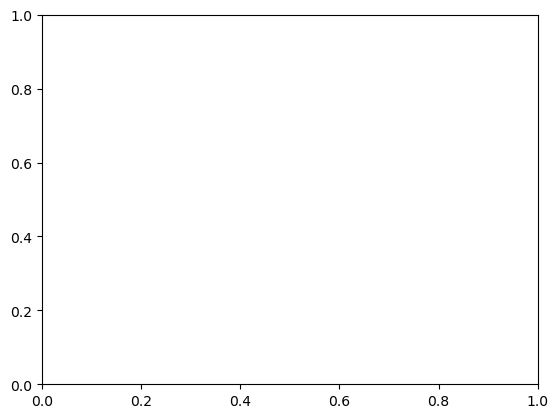

In [43]:
x = Dynamic_Hedging_Results.loc['TOTAL CASHFLOW',]
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Dynamic Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()

if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

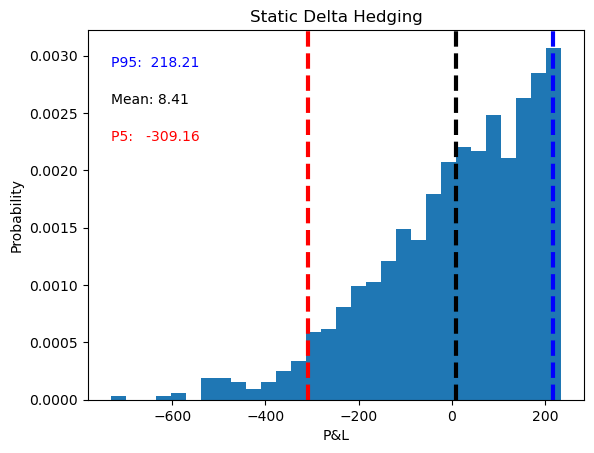

In [29]:
x = np.array(static_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Static Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

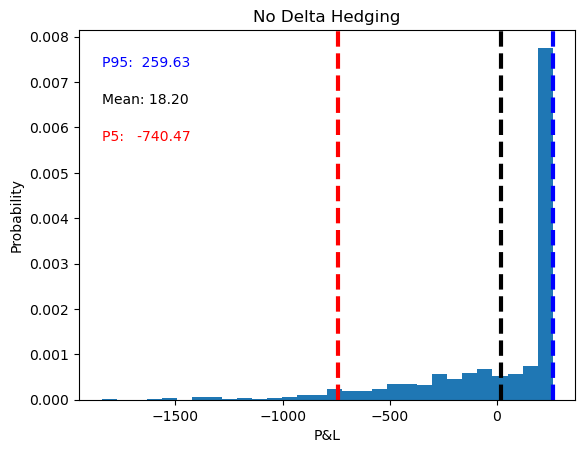

In [30]:
x = np.array(no_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('No Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')